# Data Preparation

Here in this data preparation jupyter notebook, we will prepare our data that will go into a Convolutional Neural Network model later.

## 0. Setup parameters and load libraries

In [1]:
import glob
import io
import os
import sys

import requests
import tqdm

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import quilt
import rasterio
import rasterio.mask
import rasterio.plot
import shapely.geometry
import skimage.util.shape
%matplotlib inline

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Rasterio     :', rasterio.__version__)
print('Scikit-image :', skimage.__version__)

Python       : 3.6.6 | packaged by conda-forge | (default, Jul 26 2018, 09:53:17) 
Numpy        : 1.15.2
Rasterio     : 1.0.8
Scikit-image : 0.14.1


## 1. Get Data!

### Download Low Resolution bed elevation data (e.g. [BEDMAP2](https://doi.org/10.5194/tc-7-375-2013))

In [2]:
url = "http://data.pgc.umn.edu/elev/dem/bedmap2/bedmap2_bed.tif"  #link to BEDMAP2 Bed Elevation GeoTiff
path = "lowres/bedmap2_bed.tif"  #path to download the file to

if not os.path.exists(path=path):
    r = requests.get(url=url, stream=True)
    with open(file=path, mode='wb') as fd:
        for chunk in r.iter_content(chunk_size=1024):
            fd.write(chunk)

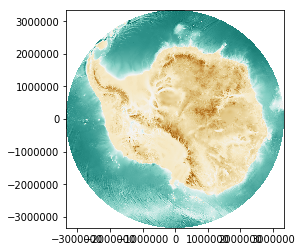

In [3]:
with rasterio.open("lowres/bedmap2_bed.tif") as raster_source:
    rasterio.plot.show(source=raster_source, cmap='BrBG_r')

### Download High Resolution bed elevation data (e.g. some-DEM-name)

In [4]:
highresDict = {"highres/bed_WGS84_grid.txt": "http://ramadda.nerc-bas.ac.uk/repository/entry/get/Polar%20Data%20Centre/DOI/Rutford%20Ice%20Stream%20bed%20elevation%20DEM%20from%20radar%20data/bed_WGS84_grid.txt?entryid=synth%3A54757cbe-0b13-4385-8b31-4dfaa1dab55e%3AL2JlZF9XR1M4NF9ncmlkLnR4dA%3D%3D",
               "highres/2009_Antarctica_DC8.csv": "https://data.cresis.ku.edu/data/rds/2009_Antarctica_DC8/csv_good/2009_Antarctica_DC8.csv",
               "highres/2009_Antarctica_TO.csv": "https://data.cresis.ku.edu/data/rds/2009_Antarctica_TO/csv_good/2009_Antarctica_TO.csv",
               "highres/2009_Antarctica_TO_Gambit.csv": "https://data.cresis.ku.edu/data/rds/2009_Antarctica_TO_Gambit/csv_good/2009_Antarctica_TO_Gambit.csv",
               "highres/2010_Antarctica_DC8.csv": "https://data.cresis.ku.edu/data/rds/2010_Antarctica_DC8/csv_good/2010_Antarctica_DC8.csv",
               "highres/2011_Antarctica_DC8.csv": "https://data.cresis.ku.edu/data/rds/2011_Antarctica_DC8/csv_good/2011_Antarctica_DC8.csv",
               "highres/2011_Antarctica_TO.csv": "https://data.cresis.ku.edu/data/rds/2011_Antarctica_TO/csv_good/2011_Antarctica_TO.csv",
               "highres/2012_Antarctica_DC8.csv": "https://data.cresis.ku.edu/data/rds/2012_Antarctica_DC8/csv_good/2012_Antarctica_DC8.csv",
               "highres/2013_Antarctica_Basler.csv": "https://data.cresis.ku.edu/data/rds/2013_Antarctica_Basler/csv_good/2013_Antarctica_Basler.csv",
               "highres/2013_Antarctica_P3.csv": "https://data.cresis.ku.edu/data/rds/2013_Antarctica_P3/csv_good/2013_Antarctica_P3.csv",
               "highres/2014_Antarctica_DC8.csv": "https://data.cresis.ku.edu/data/rds/2014_Antarctica_DC8/csv_good/2014_Antarctica_DC8.csv",
               "highres/2016_Antarctica_DC8.csv": "https://data.cresis.ku.edu/data/rds/2016_Antarctica_DC8/csv_good/2016_Antarctica_DC8.csv",
               "highres/2017_Antarctica_P3.csv": "https://data.cresis.ku.edu/data/rds/2017_Antarctica_P3/csv_good/2017_Antarctica_P3.csv"
              }

for path, url in highresDict.items():
    if not os.path.exists(path=path):
        r = requests.get(url=url, stream=True)
        with open(file=path, mode='wb') as fd:
            for chunk in r.iter_content(chunk_size=1024):
                fd.write(chunk)

### Download miscellaneous data (e.g. [REMA](https://www.pgc.umn.edu/data/rema/))

In [5]:
miscDict = {"misc/REMA_200m_dem_filled.tif": "http://data.pgc.umn.edu/elev/dem/setsm/REMA/mosaic/v1.0/200m/REMA_200m_dem_filled.tif",
            "misc/MEaSUREs_IceFlowSpeed_450m.tif": "http://data.pgc.umn.edu/gis/packages/quantarctica/Quantarctica3/Glaciology/MEaSUREs%20Ice%20Flow%20Velocity/MEaSUREs_IceFlowSpeed_450m.tif"
           }

for path, url in miscDict.items():
    if not os.path.exists(path=path):
        r = requests.get(url=url, stream=True)
        with open(file=path, mode='wb') as fd:
            for chunk in r.iter_content(chunk_size=1024):
                fd.write(chunk)

## 2. Process high resolution data into grid format

[ASCII Text](https://pdal.io/stages/readers.text.html) ----> [GeoTIFF](https://pdal.io/stages/writers.gdal.html)

![Processing pipeline](https://yuml.me/diagram/scruffy;dir:LR/class/[ASCII-Text|*.csv/*.txt/*.grd]->[PDAL-Pipeline|*.json],[PDAL-Pipeline]->[GeoTIFF|*.tif])

In [6]:
%%time
# change to highres directory, list all the json pipeline files, run pdal pipeline on each of those files
!cd highres && ls *.json | xargs -n1 pdal pipeline --nostream -i

CPU times: user 7.67 s, sys: 1.42 s, total: 9.09 s
Wall time: 7min 4s


TODO:
- use Python bindings instead of shell

CPU times: user 5.52 s, sys: 50.7 s, total: 56.2 s
Wall time: 56.2 s


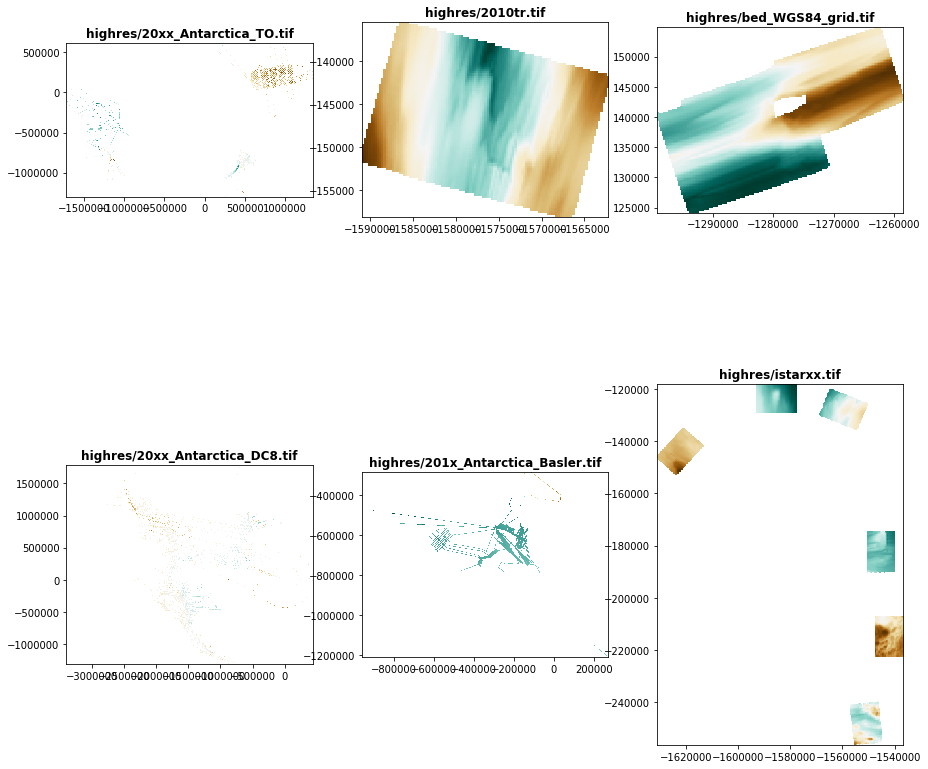

In [7]:
%%time
tifs = glob.glob("highres/*.tif")
fig, axarr = plt.subplots(nrows=1+((len(tifs)-1)//3), ncols=3, squeeze=False, figsize=(15,15))

for i, tif in enumerate(tifs):
    with rasterio.open(tif) as raster_source:
        rasterio.plot.show(source=raster_source, cmap='BrBG_r', ax=axarr[i//3,i%3], title=tif)

## 3. Tile data

### Big raster to many small square tiles

In [8]:
def get_window_bounds(filepath:str, height:int=32, width:int=32, step=4) -> list:
    """
    Reads in a raster and finds tiles for them according to a stepped moving window.
    Returns a list of bounding box coordinates corresponding to a tile that looks like
    [(minx, miny, maxx, maxy), (minx, miny, maxx, maxy), ...]
    """
    assert(height==width)  #make sure it's a square!
    assert(height%2==0)    #make sure we are passing in an even number
    
    with rasterio.open(filepath) as dataset:
        print(f'Tiling: {filepath} ... ', end='')
        #Vectorized 'loop' along the the raster image from top to bottom, and left to right
        
        #Get boolean true/false mask of where the data/nodata pixels lie
        mask = dataset.read(indexes=list(range(1,dataset.count+1)), masked=True).mask
        mask = np.rollaxis(a=mask, axis=0, start=3)[:,:,0]   #change to shape (height, width)
        
        #Sliding window view of the input geographical raster image
        window_views = skimage.util.shape.view_as_windows(arr_in=mask, window_shape=(height, width), step=step)
        filled_tiles = ~window_views.any(axis=(-2,-1))  #find tiles which are fully filled, i.e. no blank/NODATA pixels
        tile_indexes = np.argwhere(filled_tiles)  #get x and y index of filled tiles
        
        #Convert x,y tile indexes to bounding box coordinates
        windows = [rasterio.windows.Window(col_off=ulx*step, row_off=uly*step, width=width, height=height) for uly, ulx in tile_indexes]
        window_bounds = [rasterio.windows.bounds(window=window, transform=dataset.transform) for window in windows]
        print(len(window_bounds))
    
    return window_bounds

In [9]:
%%time
filepaths = glob.glob("highres/*.tif")
window_bounds = [get_window_bounds(filepath=tif) for tif in filepaths]
window_bounds_concat = np.concatenate([w for w in window_bounds]).tolist()
print(f'Total number of tiles: {len(window_bounds_concat)}')

Tiling: highres/20xx_Antarctica_TO.tif ... 963
Tiling: highres/2010tr.tif ... 131
Tiling: highres/bed_WGS84_grid.tif ... 121
Tiling: highres/20xx_Antarctica_DC8.tif ... 15
Tiling: highres/201x_Antarctica_Basler.tif ... 762
Tiling: highres/istarxx.tif ... 119
Total number of tiles: 2111
CPU times: user 11.5 s, sys: 17.2 s, total: 28.7 s
Wall time: 28.8 s


### Show tiles

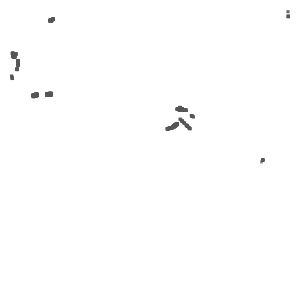

In [10]:
#shapely.geometry.box(*window_bound)
shapely.geometry.MultiPolygon([shapely.geometry.box(*bound) for bound in window_bounds_concat])

### Tile High Resolution data

In [11]:
def selective_tile(filepath:str, window_bounds:list) -> np.ndarray:
    """
    Reads in raster and tiles them selectively.
    Tiles will go according to list of window_bounds.
    """
    
    array_list = []
    
    with rasterio.open(filepath) as dataset:
        print(f'Tiling: {filepath}')
        for window_bound in window_bounds:
            window = rasterio.windows.from_bounds(*window_bound, transform=dataset.transform, precision=6)
        
            #Read the raster according to the crop window
            array = dataset.read(indexes=list(range(1,dataset.count+1)), masked=True, window=window)
            array = np.rollaxis(a=array, axis=0, start=3)   #change to shape (height, width, 1)
    
            assert(not array.mask.any())
            assert(array.shape[0]==array.shape[1])  #check that height==width
            array_list.append(array.data.astype(dtype=np.float32))
    
    return np.stack(arrays=array_list)

In [12]:
hireses = [selective_tile(filepath=f, window_bounds=w) for f, w in zip(filepaths, window_bounds)]
hires = np.concatenate(hireses)
print(hires.shape, hires.dtype)

Tiling: highres/20xx_Antarctica_TO.tif
Tiling: highres/2010tr.tif
Tiling: highres/bed_WGS84_grid.tif
Tiling: highres/20xx_Antarctica_DC8.tif
Tiling: highres/201x_Antarctica_Basler.tif
Tiling: highres/istarxx.tif
(2111, 32, 32, 1) float32


### Tile low resolution data

In [13]:
lores = selective_tile(filepath="lowres/bedmap2_bed.tif", window_bounds=window_bounds_concat)
print(lores.shape, lores.dtype)

Tiling: lowres/bedmap2_bed.tif
(2111, 8, 8, 1) float32


### Tile miscellaneous data

In [14]:
rema = selective_tile(filepath="misc/REMA_200m_dem_filled.tif", window_bounds=window_bounds_concat)
print(rema.shape, rema.dtype)

Tiling: misc/REMA_200m_dem_filled.tif
(2111, 40, 40, 1) float32


In [15]:
measuresiceflow = selective_tile(filepath="misc/MEaSUREs_IceFlowSpeed_450m.tif", window_bounds=window_bounds_concat)
print(measuresiceflow.shape, measuresiceflow.dtype)

Tiling: misc/MEaSUREs_IceFlowSpeed_450m.tif
(2111, 17, 17, 1) float32


## 4. Save the arrays

We'll save the numpy arrays to the filesystem first.
We label inputs as X (low resolution bed DEMs) and W (miscellaneous).
Groundtruth high resolution bed DEMs are labelled as Y.

Also, we'll serve the data up on the web using:
- [Quilt](https://quiltdata.com/) - Python data versioning
- [Dat](https://datproject.org/) - Distributed data sharing (TODO)

In [16]:
os.makedirs(name="model/train", exist_ok=True)
np.save(file="model/train/W1_data.npy", arr=rema)
np.save(file="model/train/W2_data.npy", arr=measuresiceflow)
np.save(file="model/train/X_data.npy", arr=lores)
np.save(file="model/train/Y_data.npy", arr=hires)

### Quilt

Login -> Build -> Push

In [17]:
quilt.login()

Launching a web browser...
If that didn't work, please visit the following URL: https://pkg.quiltdata.com/login



Enter the code from the webpage:  eyJpZCI6ICIyOWI4YzUyNS1lZmM1LTQ5NTItOGQ4Yy03NzQyYTg1YmI1MmEiLCAiY29kZSI6ICIyNmZiMzU4Zi0wYzdjLTQ5NjEtODQwNC0wMjE4ZDM0MGRmMzQifQ==


In [18]:
quilt.build(package='weiji14/deepbedmap/model/train/W1_data', path=rema)
quilt.build(package='weiji14/deepbedmap/model/train/W2_data', path=measuresiceflow)
quilt.build(package='weiji14/deepbedmap/model/train/X_data', path=lores)
quilt.build(package='weiji14/deepbedmap/model/train/Y_data', path=hires)

In [19]:
quilt.push(package='weiji14/deepbedmap', is_public=True)

Fetching upload URLs from the registry...


  0%|          | 0.00/27.5M [00:00<?, ?B/s]

Uploading 5 fragments (27512828 bytes)...


 20%|█▉        | 5.45M/27.5M [00:01<00:51, 431kB/s]

Fragment 17a96a18514c2b5a2de5d02a8bd1adbca398b6a25ea3132779c5515009bdeef1 already uploaded; skipping.
Fragment 594616b9758ffb71a6c44b40bcc0e2231ca8459677d5e001a2711337a0234841 already uploaded; skipping.
Fragment 57c2344940a147a198098df7bb1c36d08e0c07a7a12e7cb2fc33c433a2d1fdd0 already uploaded; skipping.
Fragment 8ccc2deee85f761fc9dd2815f5c12c6423939f0a32f49467dd1ee100ac56b877 already uploaded; skipping.


100%|██████████| 27.5M/27.5M [00:03<00:00, 7.14MB/s]


Uploading package metadata...
Updating the 'latest' tag...
Push complete. weiji14/deepbedmap is live:
https://quiltdata.com/package/weiji14/deepbedmap
